In [1]:
%matplotlib notebook

In [2]:
import torch, itertools
import numpy as np
import matplotlib.pyplot as plt

In [3]:
N = 10
M = 2

In [4]:
x = torch.linspace(0,1,N)

In [5]:
y = torch.linspace(0,1,N)

In [6]:
R = torch.stack([x.view(-1,1).expand(N,N), y.view(-1).expand(N,N)], dim=2)

In [7]:
def f(R): #x, y):
    x = R[:,:,0] #.view(-1)
    y = R[:,:,1] #.view(-1)
    alpha = 0.3
    L = 4
    d = 0.3
    f = 0
    f += (2-4*alpha+torch.cos(2*np.pi*x)+torch.cos(2*np.pi*y)).pow(2)
    f += (torch.sin(2*np.pi*x)+torch.sin(2*np.pi*y)).pow(2)
    f *= (L**2)/16
    f -= d**2
    f  = f.abs()
    f  = f.pow(0.5)
    return(f)

In [8]:
E = f(R) #.view(N,N)

<IPython.core.display.Javascript object>


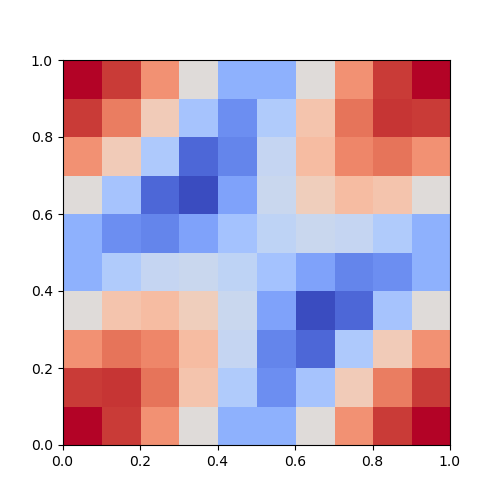

In [9]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0,1), ylim=(0,1))
im = ax.imshow(E.tolist(), interpolation='nearest', cmap='coolwarm', origin='lower', extent=[0,1,0,1], aspect='auto')

In [10]:
E = E.reshape(N,1,N,1).expand(N,M,N,M).reshape(N*M,N*M)
R = R.reshape(N,1,N,1,2).expand(N,M,N,M,2).clone()
for i in range(M):
    R[:,i,:,:,0] += (1.0/N)*float(i)/M
    R[:,:,:,i,1] += (1.0/N)*float(i)/M
R = R.reshape(N*M,N*M,2)
E_cutoff = E.unique()[5]
idx = torch.nonzero((E<E_cutoff).to(torch.long))
E[idx[:,0],idx[:,1]] = f(R)[idx[:,0],idx[:,1]] #.view(N*M,N*M)

<IPython.core.display.Javascript object>


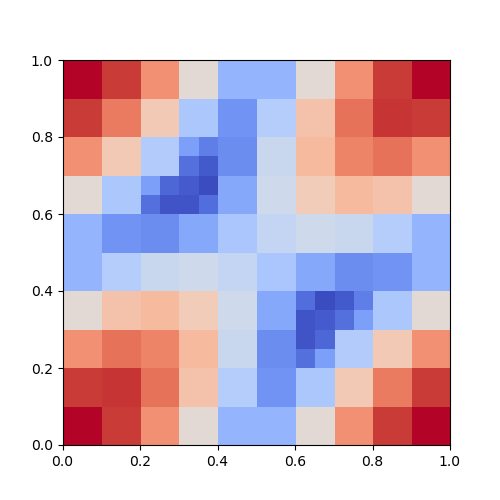

In [11]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0,1), ylim=(0,1))
im = ax.imshow(E, interpolation='nearest', cmap='coolwarm', origin='lower', extent=[0,1,0,1], aspect='auto')